# Methodology Overview
Below, we summarize each aspect of our experimental methodology. More detailed discussion follows this outline.

## Data Set Selection
We experimented on two public datasets, each representative of a different type of data that should be subject to privacy constraints. **Adult** is demographic data linked to income, and **CodRNA** is a classification task on genomic data.

## Preprocessing and Limits from Privacy
Since our algorithm works with binary features and outcomes, we need to binarize the data. To protect privacy, we use a preprocessing procedure that is be dataset oblivious and based only on prior knowledge of the range of each feature, implemented in `data/parse_generic.py`. Each dataset is divided into two sets of features:

1. **Nominal features:** For features that are nominal by nature, we use one-hot encoding to binarize them. It is important to mention that we consider missing values as a binary feature, too. We implement the one-hot encoder using scikit-learn’s built-in function.

2. **Numeric features:** For numeric features, we divide the range between minimum and maximum for a specific feature to a certain amount of bins, then we define a binary feature for each bin and encode this feature. The reason for having a certain amount of bins for all features is that we would like to do this without looking at the data, and choose these parameters before the process to make sure that the privacy is preserved. In this work, we always set the number of bins to 10, which is a value that is used in [previous work](https://arxiv.org/abs/2012.10602) and allows us to compare our results with the previous results. We implement the binning using scikit-learn’s built-in function.

## Base Learners 
We instantiate our boosting algorithm with the following base learners:

1. `OneRule` : A OneRule is a simple classifier that only looks at a single feature. To train a non-private OneRule we select the feature and sign that achieves the best accuracy on training set. On the other hand, a private OneRule uses Exponential Mechanism to select the best pair of feature and sign. Our implementation is in `weak_learner/OneRule.py`.

2. `TopDown` : TopDown decision trees are a popular family of tree induction heuristics. We use Gini index as our spliting criterion. To obtain a private TopDown decision tree, splits are selected by Exponential Mechanism using half of the privacy budget. After constructing the tree, we use the other half of the privacy budget is spent to label the leafs using Report Noisy Max. Our implementation is in `weak_learner/TopDownDT.py`.

3. `RandomForest` : A RandomForest classifier creates a number of random trees and then select the best of them with respect to training data. To maintain privacy our RandomForest classifiers uses Exponential Mechanism to choose a *single* tree from the forest. Our implementation is in `weak_learner/DPRandomForest.py`.

We choose these base learners beacause they are simple, popular, and similar to previous work. We implemented each learner from scratch, using privacy mechanisms from [IBM diffprivlib](https://github.com/IBM/differential-privacy-library). Our code is not optimized, but it ensures that the proof of privacy does indeed apply to these concrete base learners, assuming correctness of diffprivlib.

## Boosting
Our boosting algorithm, `Lazy Breg Boost,` was first introduced in [[BCS20]](http://proceedings.mlr.press/v125/bun20a.html). Intuitively `Lazy Breg Boost` never assigns too much weight to any single sample during the rounds of boosting. Therefore we never leak too much information about any single sample by releasing the model. To achieve this goal, the boosting algorithm projects the measure of the weight at each round to the set of smooth distributions using Bregman projections, which we have implemented following a characterization from previous work on hardcore lemmas in [[BHK09]](https://dl.acm.org/doi/10.5555/1496770.1496899). Our code is in `ensemble/measure_boosting.py.`

## Hyperparameter Selection & Recommendation
Hyperparameter selection for differentially private machine learning algorithms is fraught. Essentially, hyperparameters tuned by grid search or other standard methods *depend on the data* and thus *leak privacy.* Therefore, either hyperparameter tuning must be explicitly accounted for in the privacy budget or specific and "data-oblivious" values of hyperparameters must be fixed in advance.

We take the oblivious approach. We examine the results of grid-search on both Adult and CodRNA to select parameters to recommend for similar applications. The results on Adult lead to a **clear recommendation** of hyperparameters for boosting that do well for **all three** base learners we tried. The results on CodRNA are inconclusive; no setting of boosting hyperparameters dominates performance for all three base learners. Please see the section after experiments for a detailed discussion.

## Privacy Budgeting Strategies
Finally, we examined the impact of switching from pure differential privacy to approximate differential privacy for budgeting. For OneRules, **we can clearly trade approximate differential privacy for more accuracy at more stringent privacy constraints!** Please see the final section of this notebook for a detailed discussion.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

# Datasets
## Adult
**Summary:** The adult dataset was extracted from United States Census database of 1994. The prediction task associated with this dataset is to predict wether an indivual makes over 50K a year. This dataset is **particularly interesting** for privacy-preserving machine learning as Census data for each individual includes informations like annual capital-gain and relationship status which are considered to be highly sensitive and private. 

In [3]:
header_list = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
               'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
               'hours-per-week', 'native-country', 'Target']

df = pd.read_csv('data/raw/adult/adult.csv', header=None, names=header_list)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In this work, for the sake of simplicity, we only consider binary features. Hence, we have to preprocess and binarize the datasets before running our boosting algorithms. This dataset contains 8 nominal features, and 6 numeric features, which will result in 162 binary features when appropriate one-hot encoding and binning are applied.

In [4]:
from data.parse_adult import parse_adult

adult_X, adult_y, _, _ = parse_adult("data/raw/adult/adult.csv", verbose=False)

print("The adult dataset has %d rows and %d features after binarization." % adult_X.shape)

The adult dataset has 32561 rows and 162 features after binarization.


### Baseline performance on Adults dataset

We use a single non-private OneRule as a baseline for performance of our private boosting algorithms.

In [5]:
from weak_learner.OneRule import OneRule
from experiments.script import apply_random_permutation, parse_dataset

def run_baseline_experiment(dataset):
    # instantiate a non-private OneRule classifier
    clf_non_private_one_rule = OneRule()
    
    # reading the dataset and applying a random permutation to data
    X, y = parse_dataset(dataset)
    X, y = apply_random_permutation(X, y)

    # calculate the 100-fold cross-validation score
    baseline_cv = cross_val_score(clf_non_private_one_rule, X, y, cv=100)
    print('Baseline performance for %s dataset' % dataset)
    print('cross-validation average score: \t', baseline_cv.mean())
    print('cross-validation standard deviation: \t', np.std(baseline_cv))

In [6]:
run_baseline_experiment('adult')

Baseline performance for adult dataset
cross-validation average score: 	 0.7819789523360076
cross-validation standard deviation: 	 0.008169098930465628


##  Cod-RNA
**Summary:** The prediction task associated with Cod-RNA dataset is to predict wether an RNA strand is a coding or non-coding, that is whether or not it will be translated to proteins. Each row stands for a fragment of DNA and includes biological summary statistics of its two RNA strings. For more information please checkout [[AVU06a]](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173). 
Genomic data of inidivuals is highly sensitive and has to be kept private.

In [7]:
header_list = ['Dynalign Value', 'length', 'A1-freq', 'U1-freq', 'C1-freq',
              'A2-freq', 'U2-freq', 'C2-freq', 'Target']

df = pd.read_csv('data/raw/codrna/codrna.csv', header=1, names=header_list)
df.head()

,Dynalign Value,length,A1-freq,U1-freq,C1-freq,A2-freq,U2-freq,C2-freq,Target
0,-726,131,0.129771,0.328244,0.229008,0.129771,0.328244,0.229008,-1
1,-648,123,0.146341,0.333333,0.211382,0.146341,0.333333,0.211382,-1
2,-764,124,0.137097,0.322581,0.233871,0.137097,0.322581,0.233871,-1
3,-584,130,0.153846,0.392308,0.184615,0.153846,0.392308,0.184615,-1
4,-866,124,0.193548,0.169355,0.314516,0.193548,0.169355,0.314516,-1


All the features are numerical in this dataset, which will result in 80 binary features after the binning procedure is applied using 10 bins per feature.

In [8]:
from data.parse_codrna import parse_codrna

codrna_X, codrna_y, _, _ = parse_codrna("data/raw/codrna/codrna.csv", verbose=False)

print("The cod-RNA dataset has %d rows and %d features after binarization." % codrna_X.shape)

The cod-RNA dataset has 59535 rows and 80 features after binarization.


### Baseline performance on Cod-RNA dataset

In [8]:
run_baseline_experiment('codrna')

Baseline performance for codrna dataset
cross-validation average score: 	 0.7366929953189331
cross-validation standard deviation: 	 0.011261421572243647


## Experiment

In our experiments for each pair of dataset and weak leaner we traverse the whole grid of hyperparameters and run our boosting algorithm with 5-fold cross-validation. Finally we store the results in `results` sub-directory for further analysis and hyperparameter selection. We have adopted `scikit-learn` API for our estimators and we use `scikit-learn` for grid search and cross-validation.

In [4]:
from ensemble import measure_boosting as mb
from experiments.script import apply_random_permutation, parse_dataset, wkl_grid_generator, store_results
from utils.grid_gen import *
from utils.plotting import *

all_wkl_grid_axis = {'OneRule': dp_lrg_grid, 
                     'TopDown': dp_lrg_TD_grid, 
                     'RandomForest': dp_lrg_RF_grid
                    }

In [10]:
def run_experiment(dataset, weak_learner, wkl_grid_axis, verbose=2):

    # instantiating Lazy Bregman Boosting algorithm
    LazyBB_Estimator = mb.LazyBregBoost()
    
    # reading the dataset and applying a random permutation to data
    X, y = parse_dataset(dataset)
    X, y = apply_random_permutation(X, y)

    # generating the complete grid from axis
    wkl_grid = wkl_grid_generator(grid_axis=wkl_grid_axis, weak_learner=weak_learner, 
                              n_sample=X.shape[0], n_features=X.shape[1])

    # running 5-fold cross-validation for the whole the grid
    clf_LazyBreg_lrg_DP = GridSearchCV(LazyBB_Estimator, wkl_grid, 
                                       n_jobs=-1, verbose=verbose)
    clf_LazyBreg_lrg_DP.fit(X, y)

    # store the final results in result/<dataset>_<weak learner>_results.csv
    store_results(clf_LazyBreg_lrg_DP, dataset, weak_learner)

In [ ]:
# run the experiments for Cod-RNA dataset
run_experiment('codrna', 'OneRule', all_wkl_grid_axis['OneRule'], verbose=0)
run_experiment('codrna', 'TopDown', all_wkl_grid_axis['TopDown'], verbose=0)
run_experiment('codrna', 'RandomForest', all_wkl_grid_axis['RandomForest'], verbose=0)

# run the experiments for Adult dataset
run_experiment('adult', 'OneRule', all_wkl_grid_axis['OneRule'], verbose=0)
run_experiment('adult', 'TopDown', all_wkl_grid_axis['TopDown'], verbose=0)
run_experiment('adult', 'RandomForest', all_wkl_grid_axis['RandomForest'], verbose=0)

## Results and Plots

For the sake of comparision, in all the plots we show a blue-shaded area that represents to the one standard deviation band around accuracy of a single non-private `OneRule`, and serves as a performance baseline. Moreover, the red NO-DP line corresponds to the accuracy of the `NonAdaBoost` boosting algorithm with non-private `OneRule` being used as the weak learner. The reason we stick to the `OneRule` is that we didn't have a clear non-private analog of tree algorithms.

In [10]:
from utils.figures import (boosting_fig, 
                           boost_oneRule_curve, 
                           boost_DPTopDown_curve, 
                           boost_RandomForest_curve)

# turning off pandas false-positive warnings for cleaner plotting
pd.options.mode.chained_assignment = None  

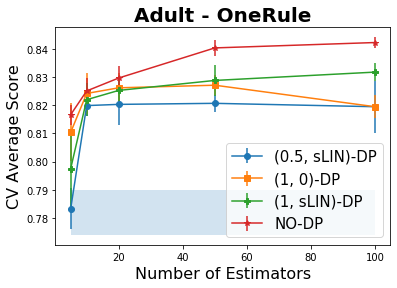

In [15]:
boosting_fig(results_csv='results/adult_OneRule_results.csv', 
             baseline_csv='results/baseline_adult_results.csv',
             dataset_name='adult',
             weak_l_curve=boost_oneRule_curve,
             title="Adult - OneRule")

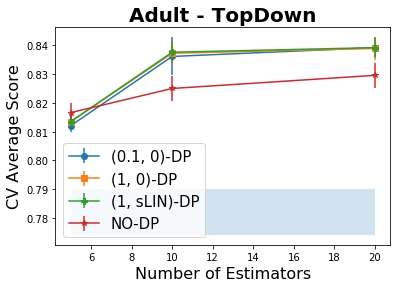

In [16]:
boosting_fig(results_csv='results/adult_TopDown_results.csv', 
             baseline_csv='results/baseline_adult_results.csv',
             dataset_name='adult',
             weak_l_curve=boost_DPTopDown_curve,
             title="Adult - TopDown")

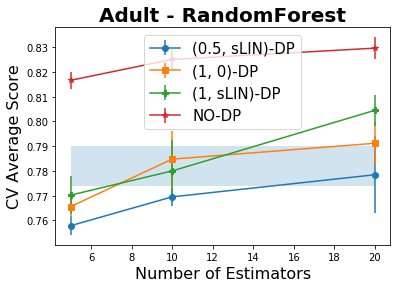

In [17]:
boosting_fig(results_csv='results/adult_RandomForest_results.csv', 
             baseline_csv='results/baseline_adult_results.csv',
             dataset_name='adult',
             weak_l_curve=boost_RandomForest_curve,
             title="Adult - RandomForest")

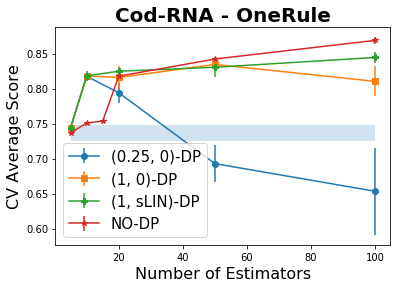

In [18]:
boosting_fig(results_csv='results/codrna_OneRule_results.csv', 
             baseline_csv='results/baseline_codrna_results.csv',
             dataset_name='codrna',
             weak_l_curve=boost_oneRule_curve,
             title="Cod-RNA - OneRule")

The blue line in the `Cod-RNA - OneRule` plot demonstrates a trade-off between privacy budget and number of rounds in the boosting algorithms. Lower total privacy budget implies lower budget available for each round of boosting, consequently to use a lower budget we have to lower the number of rounds of boosting to avoid **noise saturation**. 

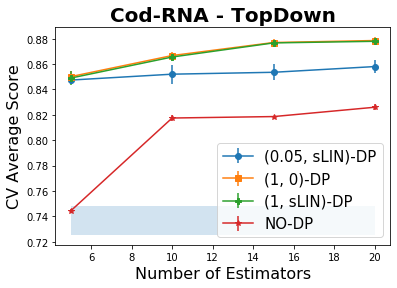

In [19]:
boosting_fig(results_csv='results/codrna_TopDown_results.csv', 
             baseline_csv='results/baseline_codrna_results.csv',
             dataset_name='codrna',
             weak_l_curve=boost_DPTopDown_curve,
             title="Cod-RNA - TopDown")

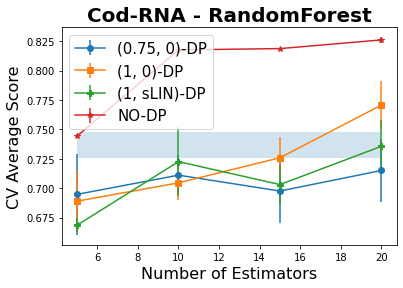

In [12]:
boosting_fig(results_csv='results/codrna_RandomForest_results.csv', 
             baseline_csv='results/baseline_codrna_results.csv',
             dataset_name='codrna',
             weak_l_curve=boost_RandomForest_curve,
             title="Cod-RNA - RandomForest")

# Privacy Budgeting
## Method
`Lazy Breg Boost` receives privacy parameters `global_epsilon` and `global_delta` as input, and is guaranteed to maintain (`global_epsilon`, `global_delta`)-DP. The algorithm then allocates a equal portion of the budget called `local_epsilon` for each round of boosting. We can use simple or advanced composition theorems to calculate the maximum possible `local_epsilon`, given `global_epsilon` and `global_delta`. 

In the case that `global_delta` is equal to zero, simple composition allways beats the advanced composition, so we have `local_epsilon = global_epsilon / n_rounds`. On the other hand, for non-zero `global_delta` we use a simple binary search to find the maximum value of `local_epsilon` that works under advanced composition.

For the details of the implementation please see the function `drv_compose_budget_search` from `utils/grid_gen.py`.

## Impact
Below, we plot pure and approximate differential privacy $\epsilon$ vs cross-validated accuracy of 100 boosted DP-OneRule base learners, with density $\kappa = .25$ and learning rate $\lambda = .25$ on the Adult dataset. This illustrates the impact that privacy budgets can have on a model.

After $\epsilon = 4$, both pure and approximate differential privacy are 1-SD indistinguishable from non-private boosted baseline. Please see Figure 2 of the paper for a version of this plot that zooms in on the medium-privacy region $0 < \epsilon < 4$ to show that, for these *stronger* privacy guarantees, pure and approximate differential privacy **are 1-SD distinguishable**. So, we can boost to a slightly more accurate model in return for accepting a small risk of catastrophic privacy failure. The decision is a normative choice left to the users of our models.

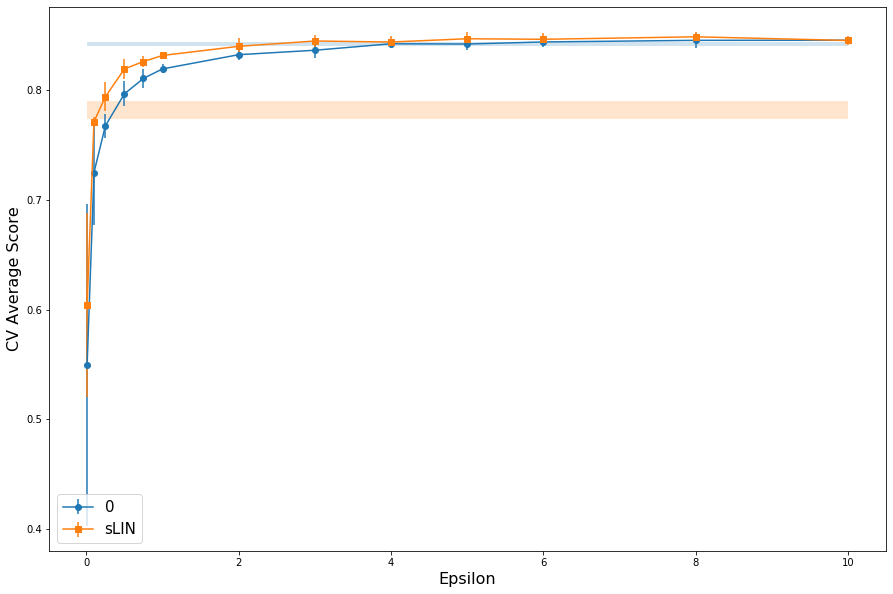

In [1]:
from utils.adult_oneRule_privacy_curve import *

# Selecting Hyperparameters
Once again, Hyperparameter selection for differentially private machine learning algorithms is fraught. Since tuned hyperparameters *depend on the data,* they *leak privacy.* Therefore, either hyperparameter tuning must be explicitly accounted for in the privacy budget or specific and "data-oblivious" values of hyperparameters must be fixed in advance. Though recent [theoretical work](https://dl.acm.org/doi/abs/10.1145/3313276.3316377) has proposed DP hyperparameter tuning methods, implementations are not yet available.

So, we take the oblivious approach: for our sample datasets, we compute summary statistics on the space of hyperparameters explored by grid search, and fix **recommended values** according to a simple heuristic counting how often they do "well" on the data. For our implementation of grid point generation and specified grid, please see `utils/grid_gen.py`.

Based on the Adult dataset, for tabular social data about individuals, we **would recommend** setting density $\kappa = .25$ and learning rate $\lambda = .25$. There parameters were *clear winners* for *all three* base learners on the Adult dataset.

Based on the CodRNA experiments, we **cannot make a recommendation** for hyperparameters to use with such genomic data. That being said, we did clearly see boosting at high privacy for many values of hyperparameters on CodRNA. So, we daparted from the heuristic and use these figures to illustrate various interesting outcomes of boosting under privacy constraints.

## Grid Heuristic
We execute the following heuristic, implemented in `utils/hyperparam.py`:

1. Read the results of grid search
2. Discard all grid-points with privacy level $\epsilon > 1$. So only points with at least medium **approximate** and **pure** DP count.
3. Select the best cross-validated average score, $b$.
4. Mark all scores within one standard deviation of $b$ as *admissable*
5. Count how many times each hyperparameter setting appears in the admissable set
6. Recommend the *most popular* hyperprameters in the admissable set, breaking ties with Occam's Razor

This is a simple function that post-processes our "results" tables, where each point on the grid is a row.

## Parameter Selections by Dataset and Base Learner

In [14]:
from utils.hyperparam import *

### Adult Dataset, OneRule Base Learner
Density $\kappa = .25$ and learning rate $\lambda = .25$ are the most popular parameter settings in the admissable set. So we plot CV score for these settings while varying number of rounds $\tau$, to show the effect of boosting.

In [15]:
pick_params("results/adult_OneRule_results.csv")

Score Cutoff is: 0.824 and 59 / 1512 = 3.902 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.25    36
0.20    23

 Learning Rate by popularity:
0.25    25
0.50    18
0.10    16

 Number of Rounds by popularity:
20     13
10     11
100    10
300    10
50      9
200     6


### Adult Dataset, TopDown Base Learner
Density $\kappa = .25$ and learning rate $\lambda = .25$ are the most popular parameter settings in the admissable set. So we plot CV score for these settings while varying number of rounds $\tau$, to show the effect of boosting. The other hyperparameters for TopDown were chosen based on recommendations from [previous work](https://arxiv.org/abs/2012.10602) on learning a *single* decision tree under DP constraints.

In [16]:
pick_params("results/adult_TopDown_results.csv")

Score Cutoff is: 0.839 and 57 / 726 = 7.851 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.25    32
0.20    22
0.10     3

 Learning Rate by popularity:
0.25    37
0.10    14
0.50     6

 Number of Rounds by popularity:
20    40
10    14
5      3


### Adult Dataset, RandomForest Base Learner
Density $\kappa = .25$ and learning rate $\lambda = .25$ are the most popular parameter settings in the admissable set. So we plot CV score for these settings while varying number of rounds $\tau$, to show the effect of boosting. Note that even though this base learner performs very poorly --- it does not escape one SD of cross-validated error around a baseline non-private OneRule --- the scores *still* improved due to boosting.

In [17]:
pick_params("results/adult_RandomForest_results.csv")

Score Cutoff is: 0.790 and 38 / 2880 = 1.319 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.25    25
0.20    13

 Learning Rate by popularity:
0.25    31
0.50     6
0.75     1

 Number of Rounds by popularity:
20    27
10     9
5      2


### CodRNA Dataset, OneRule Base Learner
Density $\kappa = .25$ and learning rate $\lambda = .5$ are the most popular parameter settings in the admissable set --- but only by one "point" in either case. So here, we departed from the popularity heuristic to illustrate an interesting featue of boosting at high privacy levels.

Theoretically, boosting would work for some low number of rounds and then completly fail for higher numbers of rounds, as noise overwhealms the signal. This very clearly occured at $\epsilon = .25$ pure-DP with the slightly more aggressive "runner-up" learning rate of $\lambda = .75$ and "runner up" $\kappa =.2$. So we plot CV score for $\kappa = .2, \lambda = .75$ while varying number of rounds $\tau$.

In [18]:
pick_params("results/codrna_OneRule_results_full.csv")

Score Cutoff is: 0.821 and 24 / 600 = 4.000 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.25    12
0.20    11
0.10     1

 Learning Rate by popularity:
0.50    11
0.75    10
0.25     3

 Number of Rounds by popularity:
100    10
50      8
10      4
20      2


### CodRNA Dataset, TopDown Base Learner

DPTopDown weak learners seems to perform for Cod-RNA even under a very high level of noise. So, to see any boosting effect, we used smaller trees with at most 3 splits. Furthermore, we could not see any difference in behavior for this dataset, even with high privacy. So we decreased the privacy budget further to 0.05, but still saw little differentiation between models.

It is unclear whether boosting is "worth it" on this type of dataset compared to a single DP decision tree; we will need to further explore the *variance* of an ensemble vs. a single tree to make a definitive recommendation.

In [20]:
pick_params("results/codrna_TopDown_results_full.csv")

Score Cutoff is: 0.842 and 55 / 120 = 45.833 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.2    55

 Learning Rate by popularity:
0.50    29
0.75    26

 Number of Rounds by popularity:
20    35
10    18
5      2


### CodRNA Dataset, RandomForest Base Learner
Lacking a clear "winner," of the hyperparameter popularity contest, we plotted the curves for $\kappa = .25$ and $\lambda = .25$ in Figure 1, to see how parameter settings derived from **Adult** behave. Though boosting is still in evidence, not even 20 "best" RandomForest trees surprases baseline. Clearly, more work is required to see if such a heavily randomized base learner can be used productively with differentially private boosting. This is in stark contrast to the other two weak learners, which perform quite well under boosting and nearly always beat non-private `OneRule` baseline.

In [21]:
pick_params("results/codrna_RandomForest_results_full.csv")

Score Cutoff is: 0.703 and 72 / 2880 = 2.500 % of settings meet it.
Next, we display parameter values sorted by how often they appear in the admissable set.

 Density by popularity:
0.20    33
0.25    31
0.10     8

 Learning Rate by popularity:
0.25    28
0.50    23
0.75    18
0.10     3

 Number of Rounds by popularity:
5     32
10    21
20    19
